In [103]:
import pandas as pd
import numpy as np
#from sdv.metadata import SingleTableMetadata
from sdv.metadata import MultiTableMetadata
from sdv.sequential import PARSynthesizer

In [104]:
itit_filled_df = pd.read_pickle('data_clean/itit_filled_df.pkl')
itit_filled_df = itit_filled_df.dropna(subset=['country_clean_filled', 'gender_filled']) #remove empty gender
itit_filled_df = itit_filled_df[itit_filled_df['age_filled'] >= 18] #inclusion criteria

In [105]:
#separate and clean
baseline_survey_filled=itit_filled_df[['trip_id_filled',
       'age_filled', 'gender_filled','country_clean_filled',
       'health_chronic_filled','smoking_status_filled','travel_purpose_filled']]
baseline_survey_filled = baseline_survey_filled.drop_duplicates(subset=['trip_id_filled'])
daily_survey_filled=itit_filled_df.drop(columns=['user_id_filled',
       'travel_date_filled', 'travel_duration_filled',
       'baseline_date_filled', 'age_filled', 'gender_filled',
       'country_iso2c_filled', 'country_clean_filled',
       'continent_clean_filled', 'health_chronic_filled', 'latitude_filled',
       'longitude_filled', 'smoking_status_filled', 'travel_purpose_filled',
       'trip_number_filled','survey_latitude_filled','survey_longitude_filled'])
daily_survey_filled['finished_filled'] = daily_survey_filled['finished_filled'].dt.date #easier for the Neural Network

In [106]:
itit_filled_presyn_df=pd.merge(baseline_survey_filled,daily_survey_filled, on=['trip_id_filled'], how='left')

In [107]:
itit_filled_presyn_df['gastro_any_filled'] = np.where(itit_filled_presyn_df.loc[:, 'nausea_filled':'constipation_filled'].apply(lambda x: x != 'none').any(axis=1), 'Yes', 'No')
itit_filled_presyn_df['respi_any_filled'] = np.where(itit_filled_presyn_df.loc[:, 'cough_filled':'out_of_breath_running_filled'].apply(lambda x: x != 'none').any(axis=1), 'Yes', 'No')
itit_filled_presyn_df['skin_any_filled'] = np.where(itit_filled_presyn_df.loc[:, 'rash_filled':'itchy_red_eyes_filled'].apply(lambda x: x != 'none').any(axis=1), 'Yes', 'No')
itit_filled_presyn_df['body_any_filled'] = np.where(
    itit_filled_presyn_df[['fever_filled','dizziness_filled', 'ear_ache_filled', 'headache_filled','pain_eyes_filled', 'musle_pain_filled', 'aching_limbs_filled','body_other_filled']].apply(
        lambda x: (x != 'none') & (x != 'No')
    ).any(axis=1), 
    'Yes', 
    'No'
)
itit_filled_presyn_df['joint_any_filled'] = np.where(itit_filled_presyn_df.loc[:, 'pain_joint_filled':'location_swelling_filled'].apply(lambda x: x != 'none').any(axis=1), 'Yes', 'No')

In [108]:
itit_filled_presyn_df.columns

Index(['trip_id_filled', 'age_filled', 'gender_filled', 'country_clean_filled',
       'health_chronic_filled', 'smoking_status_filled',
       'travel_purpose_filled', 'nausea_filled', 'vomiting_filled',
       'stomach_pain_filled', 'diarrhea_filled', 'constipation_filled',
       'cough_filled', 'sore_throat_filled', 'runny_nose_filled',
       'out_of_breath_resting_filled', 'out_of_breath_running_filled',
       'rash_filled', 'itchy_insect_bite_filled', 'itchy_other_filled',
       'sunburn_filled', 'itchy_red_eyes_filled', 'fever_filled',
       'dizziness_filled', 'ear_ache_filled', 'headache_filled',
       'pain_eyes_filled', 'musle_pain_filled', 'aching_limbs_filled',
       'pain_joint_filled', 'swelling_joint_filled',
       'location_swelling_filled', 'body_other_filled', 'impact_filled',
       'rating_day_filled', 'finished_filled', 'clouds_filled',
       'dew_point_filled', 'feels_like_filled', 'humidity_filled',
       'pressure_filled', 'rain_1h_filled', 'snow_1h_fi

In [109]:
itit_filled_presyn_df=itit_filled_presyn_df[['trip_id_filled', 'age_filled', 'gender_filled', 'country_clean_filled',
       'health_chronic_filled', 'smoking_status_filled',
       'travel_purpose_filled','finished_filled','gastro_any_filled', 'respi_any_filled', 'skin_any_filled',
       'body_any_filled','joint_any_filled']]

In [110]:
# # Create the dictionary with the data
# data = {
#     'baseline_survey': baseline_survey_filled,
#     'daily_survey': daily_survey_filled
# }

# # Use MultiTableMetadata to detect metadata from the dictionary
# metadata = MultiTableMetadata()
# metadata.detect_from_dataframes(data)
# metadata.set_sequence_key(table_name='daily_survey',column_name='trip_id_filled')
# metadata.set_sequence_index(table_name='daily_survey',column_name='finished_filled')

# # Optionally visualize the metadata
# metadata.visualize()

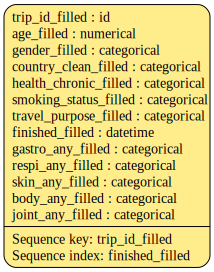

In [85]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(itit_filled_presyn_df)
metadata.update_columns_metadata(
    column_metadata={
        'trip_id_filled': {'sdtype': 'id'},
    }
)
metadata.set_sequence_key(column_name='trip_id_filled')
metadata.set_sequence_index(column_name='finished_filled')
metadata.visualize()

In [86]:
metadata.validate_data(data=itit_filled_presyn_df) #check if compatible with data

In [87]:
synthesizer = PARSynthesizer(
    metadata, # required
    enforce_min_max_values=True, #Control whether the synthetic data should adhere to the same min/max boundaries set by the real data
    enforce_rounding=True, #Control whether the synthetic data should have the same number of decimal digits as the real data
    context_columns=[ #Provide a list of strings that represent the names of the context columns. Context columns do not vary inside of a sequence.
       'age_filled', 'gender_filled','country_clean_filled',
       'health_chronic_filled','smoking_status_filled','travel_purpose_filled'],
    verbose=True #Run all the data through the neural network 128 times during training
)

/opt/homebrew/lib/python3.12/site-packages/sdv/single_table/base.py:84: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [88]:
synthesizer.fit(itit_filled_presyn_df)

Loss (-0.007): 100%|██████████| 128/128 [04:07<00:00,  1.93s/it]


In [99]:
synthetic_data = synthesizer.sample(num_sequences=600)

100%|██████████| 600/600 [00:17<00:00, 34.33it/s]


In [90]:
from sdv.evaluation.single_table import evaluate_quality
evaluate_quality(
    itit_filled_presyn_df, synthetic_data, metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |          | 0/13 [00:00<?, ?it/s]|

(1/2) Evaluating Column Shapes: |██████████| 13/13 [00:00<00:00, 252.96it/s]|
Column Shapes Score: 84.19%

(2/2) Evaluating Column Pair Trends: |██████████| 78/78 [00:00<00:00, 116.26it/s]|
Column Pair Trends Score: 64.65%

Overall Score (Average): 74.42%



In [96]:
itit_filled_presyn_df.columns

Index(['trip_id_filled', 'age_filled', 'gender_filled', 'country_clean_filled',
       'health_chronic_filled', 'smoking_status_filled',
       'travel_purpose_filled', 'finished_filled', 'gastro_any_filled',
       'respi_any_filled', 'skin_any_filled', 'body_any_filled',
       'joint_any_filled', 'gastro_any_binary'],
      dtype='object')

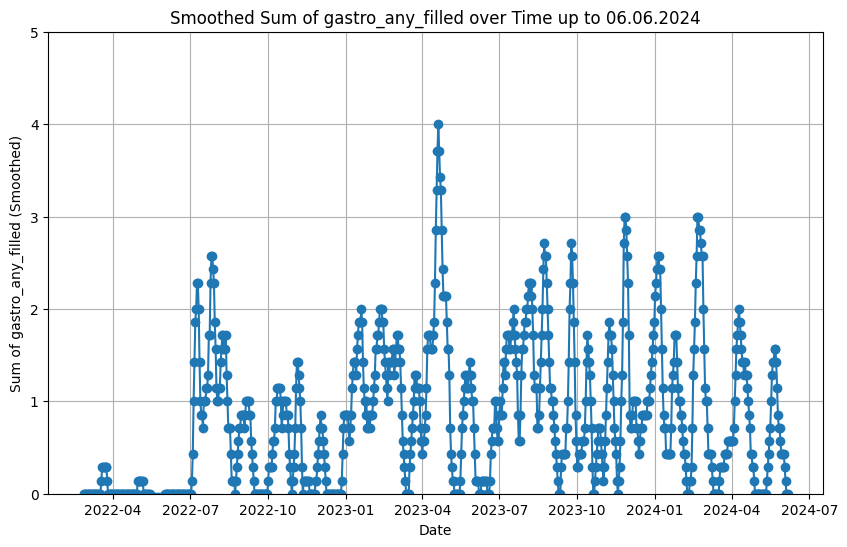

In [102]:
import matplotlib.pyplot as plt
itit_filled_presyn_df['gastro_any_binary'] = itit_filled_presyn_df['gastro_any_filled'].apply(lambda x: 1 if x == 'Yes' else 0)

# Group by finished_filled date and trip_id_filled, then sum gastro_any_binary
aggregated_data = itit_filled_presyn_df.groupby(['finished_filled', 'trip_id_filled'])['gastro_any_binary'].sum().reset_index()

# Sum the gastro_any_binary for each date
daily_sum = aggregated_data.groupby('finished_filled')['gastro_any_binary'].sum().reset_index()

end_date = pd.to_datetime('2024-06-06')
filtered_data = daily_sum[daily_sum['finished_filled'] <= end_date]

# Smooth the data using a rolling mean
window_size = 7  # Adjust the window size as needed
filtered_data['smoothed'] = filtered_data['gastro_any_binary'].rolling(window=window_size).mean()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['finished_filled'], filtered_data['smoothed'], marker='o', linestyle='-')
plt.title('Smoothed Sum of gastro_any_filled over Time up to 06.06.2024')
plt.xlabel('Date')
plt.ylabel('Sum of gastro_any_filled (Smoothed)')
plt.grid(True)
plt.ylim(0, filtered_data['smoothed'].max() + 1)  # Adjust the y-axis limit as needed
plt.show()

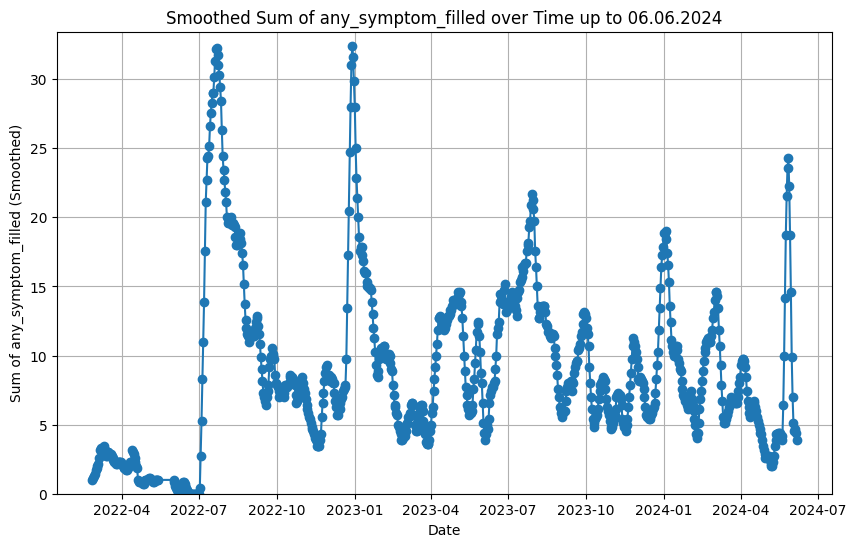

In [101]:
# Create a new binary column that checks if any specified column is 'Yes'
itit_filled_presyn_df['any_symptom_filled'] = itit_filled_presyn_df.apply(
    lambda x: 1 if any([x['gastro_any_filled'] == 'Yes', x['respi_any_filled'] == 'Yes', 
                        x['skin_any_filled'] == 'Yes', x['body_any_filled'] == 'Yes', 
                        x['joint_any_filled'] == 'Yes']) else 0, axis=1)

# Group by finished_filled date and trip_id_filled, then sum any_symptom_filled
aggregated_data = itit_filled_presyn_df.groupby(['finished_filled', 'trip_id_filled'])['any_symptom_filled'].sum().reset_index()

# Sum the any_symptom_filled for each date
daily_sum = aggregated_data.groupby('finished_filled')['any_symptom_filled'].sum().reset_index()

# Filter data up to 06.06.2024
end_date = pd.to_datetime('2024-06-06')
filtered_data = daily_sum[daily_sum['finished_filled'] <= end_date]

# Smooth the data using a rolling mean
window_size = 7  # Adjust the window size as needed
filtered_data['smoothed'] = filtered_data['any_symptom_filled'].rolling(window=window_size).mean()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['finished_filled'], filtered_data['smoothed'], marker='o', linestyle='-')
plt.title('Smoothed Sum of any_symptom_filled over Time up to 06.06.2024')
plt.xlabel('Date')
plt.ylabel('Sum of any_symptom_filled (Smoothed)')
plt.grid(True)
plt.ylim(0, filtered_data['smoothed'].max() + 1)  # Adjust the y-axis limit as needed
plt.show()

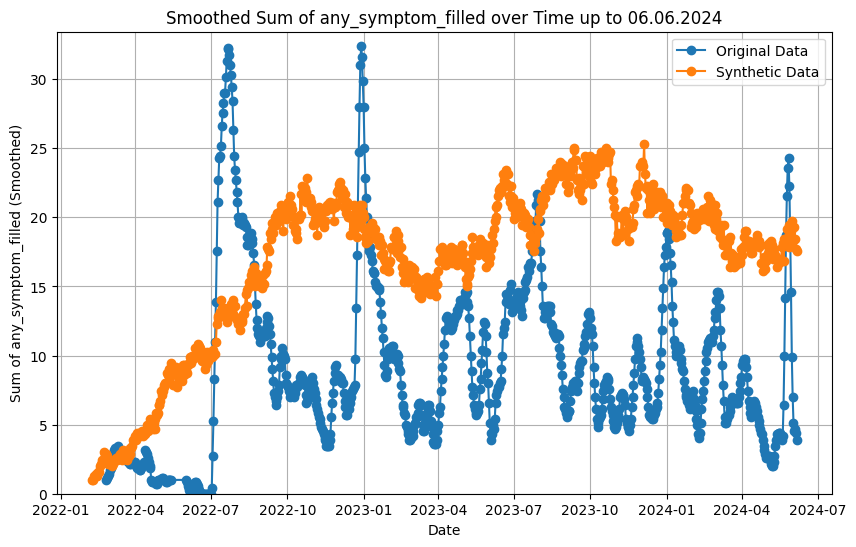

In [113]:
# Ensure finished_filled is in datetime format for both datasets
itit_filled_presyn_df['finished_filled'] = pd.to_datetime(itit_filled_presyn_df['finished_filled'])
synthetic_data['finished_filled'] = pd.to_datetime(synthetic_data['finished_filled'])
def process_data(df):
    # Create a new binary column that checks if any specified column is 'Yes'
    df['any_symptom_filled'] = df.apply(
        lambda x: 1 if any([x['gastro_any_filled'] == 'Yes', x['respi_any_filled'] == 'Yes', 
                            x['skin_any_filled'] == 'Yes', x['body_any_filled'] == 'Yes', 
                            x['joint_any_filled'] == 'Yes']) else 0, axis=1)

    # Group by finished_filled date and trip_id_filled, then sum any_symptom_filled
    aggregated_data = df.groupby(['finished_filled', 'trip_id_filled'])['any_symptom_filled'].sum().reset_index()

    # Sum the any_symptom_filled for each date
    daily_sum = aggregated_data.groupby('finished_filled')['any_symptom_filled'].sum().reset_index()

    # Filter data up to 06.06.2024
    end_date = pd.to_datetime('2024-06-06')
    filtered_data = daily_sum[daily_sum['finished_filled'] <= end_date]

    # Smooth the data using a rolling mean
    window_size = 7  # Adjust the window size as needed
    filtered_data['smoothed'] = filtered_data['any_symptom_filled'].rolling(window=window_size).mean()
    
    return filtered_data

# Process both datasets
processed_itit = process_data(itit_filled_presyn_df)
processed_synthetic = process_data(synthetic_data)

# Plot the data from both datasets
plt.figure(figsize=(10, 6))
plt.plot(processed_itit['finished_filled'], processed_itit['smoothed'], marker='o', linestyle='-', label='Original Data')
plt.plot(processed_synthetic['finished_filled'], processed_synthetic['smoothed'], marker='o', linestyle='-', label='Synthetic Data')
plt.title('Smoothed Sum of any_symptom_filled over Time up to 06.06.2024')
plt.xlabel('Date')
plt.ylabel('Sum of any_symptom_filled (Smoothed)')
plt.legend()
plt.grid(True)
plt.ylim(0, max(processed_itit['smoothed'].max(), processed_synthetic['smoothed'].max()) + 1)  # Adjust the y-axis limit as needed
plt.show()